## CSML1010 Group3 Course Project - Milestone 2 - Baseline Machine Learning Implementation
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset: __Taskmaster-1__ dataset from Google. [Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

#### Dataset Source: https://github.com/google-research-datasets/Taskmaster

---

## Notebook Setup and Data Preparation

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.7f}'.format
pd.options.display.precision = 7
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

#### Load Data

In [3]:
df_all = pd.read_csv('./data/dialog_norm.csv')
df_all.columns

Index(['Instruction_id', 'category', 'selfdialog_norm'], dtype='object')

In [4]:
df_all.head(3)

,Instruction_id,category,selfdialog_norm
0,restaurant-table,0,hi im looking book table korean fod ok area thinking somewhere southern nyc maybe east village ok great theres thursday kitchen great reviews thats great need table tonight pm people dont want sit bar anywhere else fine dont availability pm times available yikes cant times ok second choice let check ok lets try boka free people yes great lets book ok great requests thats book great use account open yes please great get confirmation phone soon
1,movie-tickets-1,1,hi would like see movie men want playing yes showing would like purchase ticket yes friend two tickets please okay time moving playing today movie showing pm okay anymore movies showing around pm yes showing pm green book two men dealing racisim oh recommend anything else like well like movies funny like comedies well like action well okay train dragon playing pm okay get two tickets want cancel tickets men want yes please okay problem much cost said two adult tickets yes okay okay anything else help yes bring food theater sorry purchase food lobby okay fine thank enjoy movie
2,movie-tickets-3,2,want watch avengers endgame want watch bangkok close hotel currently staying sounds good time want watch movie oclock many tickets two use account already movie theater yes seems movie time lets watch another movie movie want watch lets watch train dragon newest one yes one dont think movie playing time either neither choices playing time want watch afraid longer interested watching movie well great day sir thank welcome


#### Remove NaN rows

In [5]:
print(df_all.shape)
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)
df_all = df_all[df_all.selfdialog_norm != '']
print(df_all.shape)

(7705, 3)
(7705, 3)


In [6]:
print (df_all.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    1160
coffee-ordering       1376
movie-finder            54
movie-tickets-1        678
movie-tickets-2        377
movie-tickets-3        195
pizza-ordering        1467
restaurant-table      1198
restaurant-table-3     102
uber-lyft             1098
dtype: int64


In [7]:
no_of_samples = 4000
small_classes_count = 54 + 195 + 102 + 377
smp_per_cls = (no_of_samples - small_classes_count)//6
delta = no_of_samples - small_classes_count - (smp_per_cls * 6)
print(smp_per_cls, delta)

545 2


In [8]:
#weight_higher = ['restaurant-table-2', 'movie-tickets-1', 'movie-tickets-3','uber-lift-2','coffee-ordering-1','coffee-ordering-2','pizza-ordering-2','movie-finder']
# class_sample_size_dict = { #2000 Samples
#     "auto-repair-appt-1": 230,
#     "coffee-ordering": 230,
#     "movie-finder": 54,
#     "movie-tickets-1": 250,
#     "movie-tickets-2": 250,
#     "movie-tickets-3": 195,
#     "pizza-ordering": 230,
#     "restaurant-table": 230,
#     "restaurant-table-3": 101,
#     "uber-lyft": 230
# }
class_sample_size_dict = { # 3000 Samples
    "auto-repair-appt-1": smp_per_cls - 100,
    "coffee-ordering": smp_per_cls,
    "movie-finder": 54,
    "movie-tickets-1": smp_per_cls + delta + 100,
    "movie-tickets-2": 377,
    "movie-tickets-3": 195,
    "pizza-ordering": smp_per_cls,
    "restaurant-table": smp_per_cls,
    "restaurant-table-3": 102,
    "uber-lyft": smp_per_cls
}
sum(class_sample_size_dict.values())

4000

#### Get a Sample of records.

In [9]:
# Function to Get balanced Sample - Get a bit more than needed then down sample
def sampling_k_elements(group):
    name = group['Instruction_id'].iloc[0]
    k = class_sample_size_dict[name]
    return group.sample(k, random_state=5)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)
print (corpus_df.groupby('Instruction_id').size(), corpus_df.shape)

Instruction_id
auto-repair-appt-1    445
coffee-ordering       545
movie-finder           54
movie-tickets-1       647
movie-tickets-2       377
movie-tickets-3       195
pizza-ordering        545
restaurant-table      545
restaurant-table-3    102
uber-lyft             545
dtype: int64 (4000, 3)


#### Generate Corpus List

In [10]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm)

print(len(doc_lst))
doc_lst[1:5]

4000


['hi im issue car help sure whats problem light came saying headlight ok want get fixed right away today would ideal already know want take yes intelligent auto solutions ok let pull website online scheduler see today ok im looks like two appointments open today could minutes im least minutes away ok time would pm tonight tell able fix spot call confirm makemodel car kia soul ok said parts done appointment thats great news please book yes booked online thanks give info yes text youll phone thank big help',
 'hi schedule appointment car okay auto repair shop would like check check intelligent auto solutions car bringing lexus im driving put name cell phone number yes put jeff green cell phone number seems problem car makes sound step brakes anything else would like check like oil change maintenance yes think im due oil change well got let check online see available check bring mins able make appointment bring car time pm great thanks initial cost brake checkup oil change okay accept cre

#### Split Data into Train and Test Sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['category'], test_size=0.25, random_state = 0)

#### Build Vocabulary

In [12]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(X_train)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in X_train]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 10408
Vocabulary Sample: [('like', 1), ('would', 2), ('ok', 3), ('okay', 4), ('yes', 5), ('pm', 6), ('want', 7), ('tickets', 8), ('order', 9), ('thank', 10)]


### Bag of Words Feature Extraction

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(X_train, y_train)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 2, 2, ..., 0, 0, 0],
       [0, 2, 1, ..., 0, 0, 0],
       ...,
       [0, 9, 5, ..., 0, 1, 0],
       [0, 4, 5, ..., 0, 0, 0],
       [0, 3, 3, ..., 0, 0, 1]], dtype=int64)

In [14]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,ok,okay,yes,pm,want,tickets,order,thank,please,time,need,great,...,neighbors,hunt,burglar,glowing,maclay,wks,icc,urgh,sz,ivbcm,hips,raised,alexander,carmichael,meatless
0,0,0,0,1,1,1,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,2,3,0,1,0,5,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,1,0,2,2,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,5,0,4,0,7,0,4,0,0,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,3,5,0,4,1,3,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0,5,5,1,5,3,0,2,0,7,3,3,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2996,0,1,0,0,7,3,1,0,0,0,1,1,2,1,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2997,0,9,5,0,6,0,7,1,2,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2998,0,4,5,1,7,1,0,0,0,4,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Get BOW features
X_train_bow = cv_matrix #cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(3000, 10408)
(1000, 10408)
(1000,)


#### Define Model Builder Function

In [16]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

class Result_Metrics:
    def __init__(self, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()
    precision = metrics.precision_score(labels_test, pred, average='weighted')
    recall = metrics.recall_score(labels_test, pred, average='weighted')
    
    rm = Result_Metrics(pred, cm, report, f1, accuracy, precision, recall)

    return rm

### Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [17]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
rm_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [18]:

def Save_Benchmark(descr, feat_type, b_metrics, reset_rb, reset_rb_all):
    global rows_benchmarks
    global rows_benchmarks_all
    global df_benchmarks
    global df_benchmarks_all
    if (reset_rb):
        rows_benchmarks = []

    if (reset_rb_all):
        rows_benchmarks_all = []
    rows_benchmarks.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    rows_benchmarks_all.append([descr, feat_type, b_metrics.precision, b_metrics.recall, b_metrics.f1_score, b_metrics.accuracy])
    df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])
    df_benchmarks_all = pd.DataFrame(rows_benchmarks_all, columns=["Features_Benchedmarked", "Feat_Type", "Precision", "Recall", "f1_score", "accuracy"])


In [19]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Baseline", "BOW", rm_nb_bow, True, True)
#df_benchmarks

In [20]:
from sklearn.metrics import confusion_matrix
#rm_nb_bow.cm

In [21]:
from sklearn import metrics
#print("Label" + rm_nb_bow.report)

### Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Functions

In [22]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

class Result_Metrics_selected:
    def __init__(self, x_train_sel, x_test_sel, predicter, cm, report, f1_score, accuracy, precision, recall):
        self.x_train_sel = x_train_sel
        self.x_test_sel = x_test_sel
        self.predicter = predicter
        self.cm = cm    # instance variable unique to each instance
        self.report = report
        self.f1_score = f1_score
        self.accuracy = accuracy
        self.precision = precision
        self.recall = recall

def Get_Scaled_Features(features_train, labels_train, features_test, labels_test, scaler):
    x_train_scaled = scaler.fit_transform(features_train, labels_train)
    x_test_scaled = scaler.transform(features_test)
    return x_train_scaled, x_test_scaled

def Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test):
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(features_train, labels_train)
    chi_support = chi_selector.get_support()    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    return X_train_chi, X_test_chi

def Get_Model_Feature_Metrics(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_train_chi, X_test_chi = Select_Best_Features_Chi(num_feats, features_train, labels_train, features_test, labels_test)
    x_train_scaled, x_test_scaled = Get_Scaled_Features(X_train_chi, labels_train, X_test_chi, labels_test, scaler)
    rm_chi = Build_Model(model, x_train_scaled, labels_train, x_test_scaled, labels_test)
    return rm_chi

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test, scaler):
    X_norm = scaler.fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]

    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()
    precision_chi = metrics.precision_score(labels_test, predict_chi, average='weighted')
    recall_chi = metrics.recall_score(labels_test, predict_chi, average='weighted')
    
    rm_chi = Result_Metrics_selected(X_train_chi, X_test_chi, predict_chi, cm_chi, report_chi, f1_chi, accuracy_chi, precision_chi, recall_chi)

    return rm_chi

#### Iterate through number of features and get benchmark results

In [23]:
a = 100
tot = X_train_bow.shape[1]
b = 100 * (tot//100)
c = 100
print(a, b, c)

100 10400 100


In [24]:
rows = []

scaler_min_max = MinMaxScaler()
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    #rm_chi_i = Get_Model_Feature_Metrics(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


10300/10400

#### Plot f1-score by number of selected features

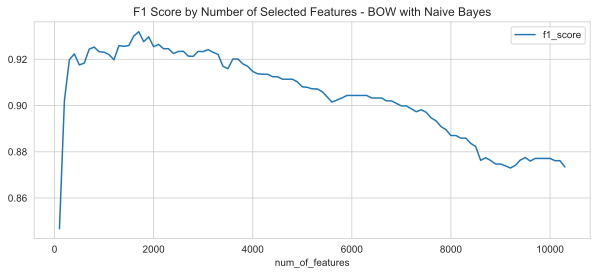

In [25]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [26]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

1650 1750 1


#### Get a more fine-grained look at the optimal number of features region

In [27]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.
    rm_chi_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)
    rows.append([i, rm_chi_i.f1_score, rm_chi_i.accuracy])
    sys.stdout.write('\r'+str(i) + "/" + str(b))
    sys.stdout.flush()

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

1749/1750

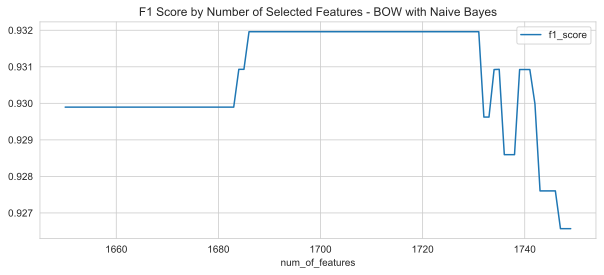

In [28]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [29]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
#acc_df.sort_values(by='f1_score', ascending=False).head(5)

1700


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [30]:
model_nb_bow_opt = MultinomialNB()
rm_chi_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test, scaler_min_max)

In [31]:
#print(rm_chi_opt_bow.cm)

In [32]:
#print("Label" + rm_chi_opt_bow.report)

In [33]:
# Save benchmark output
Save_Benchmark("BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), "BOW", rm_chi_opt_bow, False, False)
df_benchmarks

,Features_Benchedmarked,Feat_Type,Precision,Recall,f1_score,accuracy
0,BOW Naive Bayes Baseline,BOW,0.8831366,0.8890000,0.8719392,0.8890000
1,BOW Naive Bayes Optimal Features Selected: 1700,BOW,0.9423097,0.9390000,0.9319601,0.9390000


---

## 1. Benchmark Comparison

### Benchmark the following four models: Logistic Regression (Multinomial) Naive Bayes Linear Support Vector Machine Random Forest

In [34]:
# Manage Results List
def Result_Update_Or_Append(model_id, model_name, feat_status, hyper_param_status, best_params, f1_score, reset_entr):
    global entries
    if (reset_entr):
        entries = {}
    entries[model_id+model_name+feat_status+hyper_param_status] = [model_id, model_name, feat_status, hyper_param_status, best_params, f1_score]

    result_list = list(entries.values())
    return result_list

#### Baseline Features

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

model_ids = ['RF', 'SVC', 'NB','LR']
models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
reset_entries = True
#entries = []

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, X_train_bow, y_train, scoring='f1_weighted', cv=CV)
    #precisions = cross_val_score(model, X_train_bow, y_train, scoring='precision_weighted', cv=CV)
    #recalls = cross_val_score(model, X_train_bow, y_train, scoring='recall_weighted', cv=CV)
    
    results = Result_Update_Or_Append(model_id, model_name, 'baseline', 'default', '', f1_scores.mean(), reset_entries)
    print("Mean F1 Score: %.2f (+/- %.2f) [%s]" %(f1_scores.mean(), f1_scores.std(), model_name))
    
    # for i in range(0, 9, 1):
    #     Result_Update_Or_Append(model_id, model_name, 'baseline', 'default', '', f1_scores[i], reset_entries)
    reset_entries = False

cv_df = pd.DataFrame(results, columns=['Model_Id', 'Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])       

Mean F1 Score: 0.86 (+/- 0.02) [RandomForestClassifier]
Mean F1 Score: 0.91 (+/- 0.01) [LinearSVC]
Mean F1 Score: 0.86 (+/- 0.01) [MultinomialNB]
Mean F1 Score: 0.92 (+/- 0.01) [LogisticRegression]


#### Optimised Features

In [36]:

models = [
    RandomForestClassifier(n_jobs=-1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(n_jobs=-1)
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))

for model, model_id in zip(models, model_ids):
    model_name = model.__class__.__name__
    f1_scores = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='f1_weighted', cv=CV)
    #precisions = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='precision_weighted', cv=CV)
    #recalls = cross_val_score(model, rm_chi_opt_bow.x_train_sel, y_train, scoring='recall_weighted', cv=CV)
    
    results = Result_Update_Or_Append(model_id, model_name, 'optimized', 'default', '', f1_scores.mean(), False)
    print("Mean F1 Score: %.2f (+/- %.2f) [%s]" %(f1_scores.mean(), f1_scores.std(), model_name))

    # for i in range(0, 9, 1):
    #     Result_Update_Or_Append(model_id, model_name, 'optimized', 'default', '', f1_scores[i], False)
    #     #entries.append((model_name, 'optimized', precisions[i], recalls[i], f1_scores[i]))

cv_df = pd.DataFrame(results, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])        

Mean F1 Score: 0.88 (+/- 0.01) [RandomForestClassifier]
Mean F1 Score: 0.89 (+/- 0.02) [LinearSVC]
Mean F1 Score: 0.93 (+/- 0.02) [MultinomialNB]
Mean F1 Score: 0.92 (+/- 0.02) [LogisticRegression]


### Modeling

Four different models were verified as part of our modeling: 
+ Random Forest
+ Linear SVC
+ Multinomial Naïve Bayes
+ Logistic Regression 

The modeling was first done on our baseline features and using the selected optimised features identified as part of milestone 1: Naïve Bayes using Chi Squared.

In [37]:
from IPython.display import display, HTML

# #models_df = cv_df.groupby(['Model_Id', 'Model','Features', 'Hyper_Param', 'Best_Params']).agg(['mean'])
# models_df = cv_df.groupby(['Model_Id', 'Model','Features', 'Hyper_Param', 'Best_Params']).agg(['mean'])
# models_df.columns = models_df.columns.map('_'.join)
# models_df
#cv_df
#display(HTML(cv_df.to_html()))
display(cv_df)

,Model_Id,Model,Features,Hyper_Param,Best_Params,F1_Score
0,RF,RandomForestClassifier,baseline,default,,0.8553093
1,SVC,LinearSVC,baseline,default,,0.9093070
2,NB,MultinomialNB,baseline,default,,0.8601395
3,LR,LogisticRegression,baseline,default,,0.9179669
4,RF,RandomForestClassifier,optimized,default,,0.8818303
5,SVC,LinearSVC,optimized,default,,0.8946894
6,NB,MultinomialNB,optimized,default,,0.9263994
7,LR,LogisticRegression,optimized,default,,0.9176636


In [38]:
# import seaborn as sns

# fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2, sharex=True)
# sns.boxplot(x='Model', y='F1_Score', data=cv_df, hue='Features', ax=ax1);
# #sns.stripplot(x='Model', y='F1_Score', data=cv_df, hue='Features', size=6, jitter=True, edgecolor="gray", linewidth=2, ax=ax1);
# sns.barplot(y='F1_Score', x='Model', data=cv_df, palette="colorblind", hue='Features', ax=ax2);


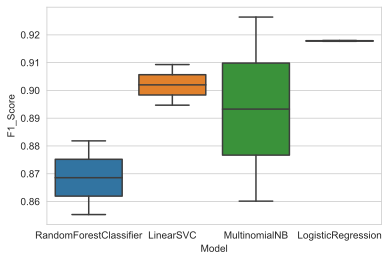

In [39]:
import seaborn as sns

sns.boxplot(x='Model', y='F1_Score', data=cv_df)

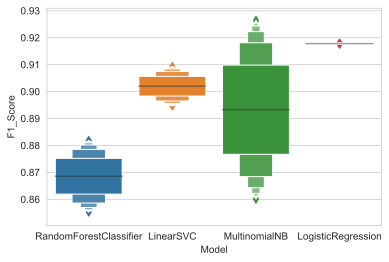

In [40]:
sns.lvplot(x='Model', y='F1_Score', data=cv_df)

## Optimize the Hyperparameters Using Grid Search

In [41]:
from sklearn.model_selection import GridSearchCV

class Estimator_Parameters:
    def __init__(self, estimator, parameters, feat_type, x, y):
        self.estimator = estimator
        self.parameters = parameters
        self.feat_type = feat_type
        self.x = x
        self.y = y

def Get_Best_Parameters(est_param):
    grid_search = GridSearchCV(estimator = est_param.estimator,
                            param_grid = est_param.parameters,
                            scoring = 'f1_weighted',
                            cv= 10,
                            n_jobs = -1)
    grid_search = grid_search.fit(est_param.x, est_param.y)
    return grid_search.best_score_, grid_search.best_params_

In [42]:
from sklearn.model_selection import GridSearchCV

est_param_arr = [
    Estimator_Parameters(RandomForestClassifier(), [{'n_estimators': [90,100,110],'max_depth': [4,5,6], 'random_state': [0,1,2]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LinearSVC(), [{'C': [1200, 1300, 1400, 1500],'loss': ['hinge', 'squared_hinge'], 'dual': [True, False], 'penalty': ['l1', 'l2'], 'max_iter': [900,1000,1100]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(MultinomialNB(), [{'alpha': [0.3,0.4,0.42,0.44,0.46],'fit_prior': [True, False]}], "optimized", rm_chi_opt_bow.x_train_sel, y_train),
    Estimator_Parameters(LogisticRegression(), [{'C': [0.1, 0.5,1,2,3], 'penalty': ['l1', 'l2', 'elasticnet', 'none'],'dual': [True, False], 'multi_class': ['auto', 'ovr', 'multinomial']}], "optimized", rm_chi_opt_bow.x_train_sel, y_train)
]

grid_dict = {}

for est_param, model_id in zip(est_param_arr, model_ids):
    estimator_name = est_param.estimator.__class__.__name__
    best_accuracy, best_parameters = Get_Best_Parameters(est_param)
    results = Result_Update_Or_Append(model_id, estimator_name, est_param.feat_type, 'tuned', str(best_parameters), best_accuracy, False)
    print(estimator_name, best_accuracy, best_parameters, est_param.feat_type)
    grid_dict[estimator_name] = best_parameters
cv_df = pd.DataFrame(results, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])   

RandomForestClassifier 0.7435265128880353 {'max_depth': 6, 'n_estimators': 110, 'random_state': 0} optimized
LinearSVC 0.8929359501849143 {'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1100, 'penalty': 'l1'} optimized
MultinomialNB 0.9462985386029604 {'alpha': 0.46, 'fit_prior': False} optimized
LogisticRegression 0.9178687963522714 {'C': 0.5, 'dual': False, 'multi_class': 'auto', 'penalty': 'l2'} optimized


### Parameter Tuning
The model's hyperparameters were optimized using the GridSearchCV function from sci-kitlearn.  The hyperparameters verified were:
+ __Random Forest:__ max_depth; n_estimators; random_state
+ __Linear SVC:__ C; dual; loss; max_iter; penalty
+ __MultinomialNB:__ alpha; fit_prior
+ __Logistic Regression:__ C; dual; multi_class; auto; penalty


In [43]:
cv_df

,Model_Id,Model,Features,Hyper_Param,Best_Params,F1_Score
0,RF,RandomForestClassifier,baseline,default,,0.8553093
1,SVC,LinearSVC,baseline,default,,0.9093070
2,NB,MultinomialNB,baseline,default,,0.8601395
3,LR,LogisticRegression,baseline,default,,0.9179669
4,RF,RandomForestClassifier,optimized,default,,0.8818303
5,SVC,LinearSVC,optimized,default,,0.8946894
6,NB,MultinomialNB,optimized,default,,0.9263994
7,LR,LogisticRegression,optimized,default,,0.9176636
8,RF,RandomForestClassifier,optimized,tuned,"{'max_depth': 6, 'n_estimators': 110, 'random_state': 0}",0.7435265
9,SVC,LinearSVC,optimized,tuned,"{'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1100, 'penalty': 'l1'}",0.8929360


## 2. a. Learning Curves: Training/ Testing Errors - Optimized Hyperarameters

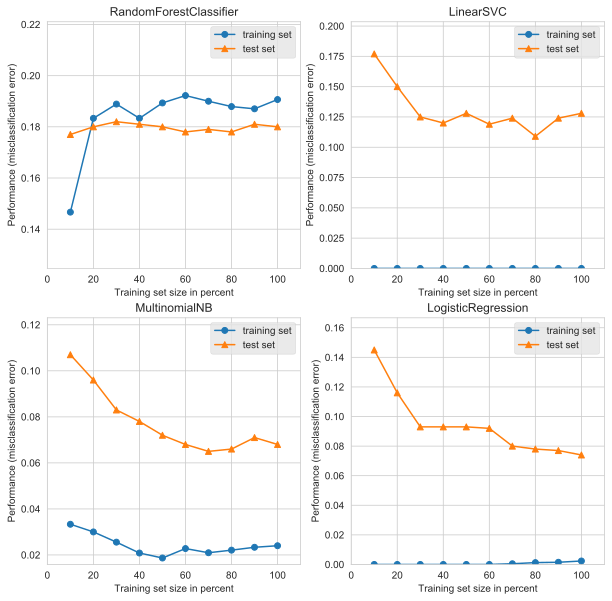

In [44]:
from mlxtend.plotting import plot_learning_curves
import itertools
import matplotlib.gridspec as gridspec

models = [
    RandomForestClassifier(**grid_dict['RandomForestClassifier']),
    LinearSVC(**grid_dict['LinearSVC']),
    MultinomialNB(**grid_dict['MultinomialNB']),
    LogisticRegression(**grid_dict['LogisticRegression']),
]

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

---

## 2. b. Learning Curves: Training/Testing Accuracy - Optimized Hyperarameters

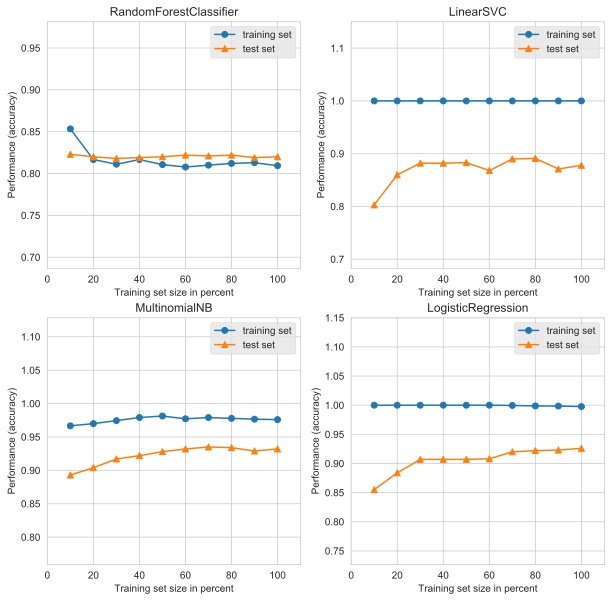

In [45]:
from mlxtend.plotting import plot_learning_curves
import matplotlib.gridspec as gridspec
import itertools

models = [
    RandomForestClassifier(**grid_dict['RandomForestClassifier']),
    LinearSVC(**grid_dict['LinearSVC']),
    MultinomialNB(**grid_dict['MultinomialNB']),
    LogisticRegression(**grid_dict['LogisticRegression']),
]

fig3 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, grd in zip(models, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig3 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, scoring='accuracy', print_model=False, style='ggplot')
    plt.title(model_name)
         
plt.show()

### Learning Curves
The learning curves for training/testing indicated the following: low error and a high gap between the training and the validation curves.  This indicates:
+ High variance
+ Low bias

Increasing the number of samples gave us more convergence on our curves, but two of the models continue to indicate 100% validation indicating more samples are required.

#### Initialize Models with optimized hyperparameters

In [46]:
clf1 = RandomForestClassifier(**grid_dict['RandomForestClassifier'])
clf2 = LinearSVC(**grid_dict['LinearSVC'])
clf3 = MultinomialNB(**grid_dict['MultinomialNB'])
clf4 = LogisticRegression(**grid_dict['LogisticRegression'])
clf_list = [clf1, clf2, clf3, clf4]

## ROC/ AUC

In [47]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle

# # Binarize the output
y_tr = label_binarize(y_train, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y_tr.shape[1]
y_te = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes_te = y_te.shape[1]

random_state = np.random.RandomState(0)

y_score_dict = dict()
labels = ['RF', 'SVC', 'NB','LR']
roc_dict = dict()

for clf, label in zip(clf_list, labels):
    classifier = OneVsRestClassifier(clf)
    if label == 'SVC':        
        y_score = classifier.fit(rm_chi_opt_bow.x_train_sel, y_tr).decision_function(rm_chi_opt_bow.x_test_sel)
        y_score_dict[label] = y_score
    else:
        y_score = classifier.fit(rm_chi_opt_bow.x_train_sel, y_tr).predict_proba(rm_chi_opt_bow.x_test_sel)
        y_score_dict[label] = y_score

In [48]:
for label in labels:
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        #print(i)
        fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score_dict[label][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_te.ravel(), y_score_dict[label].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    roc_dict[label] = [fpr, tpr, roc_auc, all_fpr, mean_tpr]

#### Visuaize ROC Curves

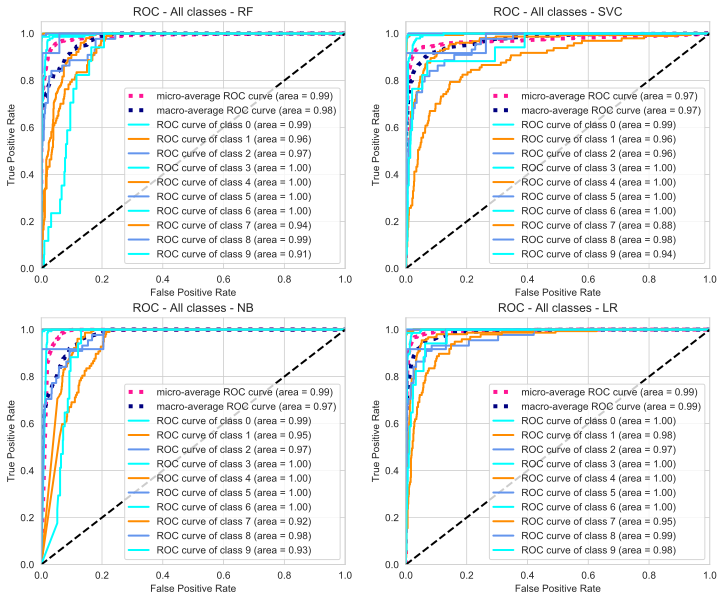

In [49]:
from itertools import cycle

lw = 2

fig2 = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for label, grd in zip(labels, grid):      
      ax = plt.subplot(gs[grd[0], grd[1]])

      # Plot ROC curves for all Classes
      #plt.figure()
      plt.plot(roc_dict[label][0]["micro"], roc_dict[label][1]["micro"], 
            label='micro-average ROC curve (area = {0:0.2f})' ''.format(roc_dict[label][2]["micro"]), color='deeppink', linestyle=':', linewidth=4)
      plt.plot(roc_dict[label][0]["macro"], roc_dict[label][1]["macro"], 
            label='macro-average ROC curve (area = {0:0.2f})' ''.format(roc_dict[label][2]["macro"]), color='navy', linestyle=':', linewidth=4)

      colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
      for i, color in zip(range(n_classes), colors):
            plt.plot(roc_dict[label][0][i], roc_dict[label][1][i], color=color, lw=lw, 
                  label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_dict[label][2][i]))

      plt.plot([0, 1], [0, 1], 'k--', lw=lw)
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC - All classes - ' + label)
      plt.legend(loc="lower right")
      #plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))

#### Compute Weighted AUC Scores

In [50]:
rows = []
labels = ['RF', 'SVC', 'NB','LR']
for label in  labels:
      macro_roc_auc_ovo = roc_auc_score(y_te, y_score_dict[label], multi_class="ovo", average="macro")
      weighted_roc_auc_ovo = roc_auc_score(y_te, y_score_dict[label], multi_class="ovo", average="weighted")
      macro_roc_auc_ovr = roc_auc_score(y_te, y_score_dict[label], multi_class="ovr", average="macro")
      weighted_roc_auc_ovr = roc_auc_score(y_te, y_score_dict[label], multi_class="ovr", average="weighted")

      rows.append([label, macro_roc_auc_ovo, weighted_roc_auc_ovo, macro_roc_auc_ovr, weighted_roc_auc_ovr])

print('Agregated ROC AUC scores:')
cv_df = pd.DataFrame(rows, columns=['Model_Id','One-vs-One Macro', 'One-vs-One Weighted', 'One-vs-Rest Macro', 'One-vs-Rest Weighted',])
cv_df

Agregated ROC AUC scores:


,Model_Id,One-vs-One Macro,One-vs-One Weighted,One-vs-Rest Macro,One-vs-Rest Weighted
0,RF,0.9775319,0.9847011,0.9775319,0.9847011
1,SVC,0.9713004,0.9782915,0.9713004,0.9782915
2,NB,0.9746508,0.9811893,0.9746508,0.9811893
3,LR,0.9862607,0.9898052,0.9862607,0.9898052


---

## 3. Ensemble Learning

## Bagging

In [51]:
from sklearn.ensemble import BaggingClassifier

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=10, max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=10, max_samples=0.8)

## Learning Curves for Bagged Models

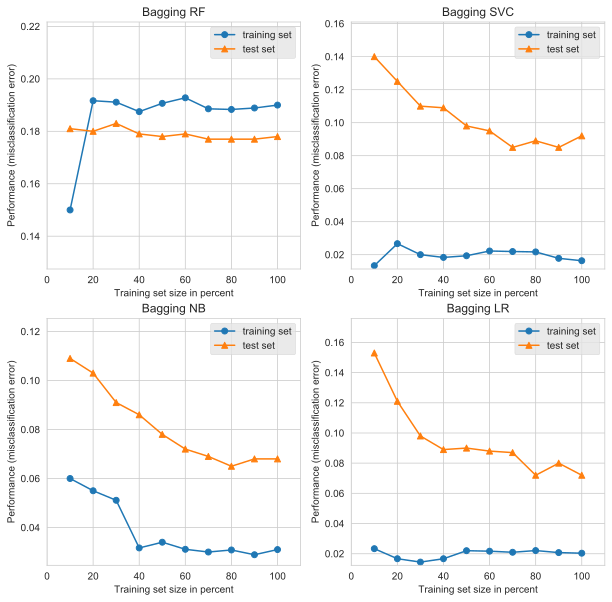

In [52]:
from mlxtend.plotting import plot_learning_curves

models = [
    bagging1, bagging2, bagging3, bagging4
]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for model, label, grd in zip(models, labels, grid):    
    model_name = model.__class__.__name__
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig2 = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, model, print_model=False, style='ggplot')
    plt.title(label)
         
plt.show()

## Bagging Scores Varied by Ensemble Size

---

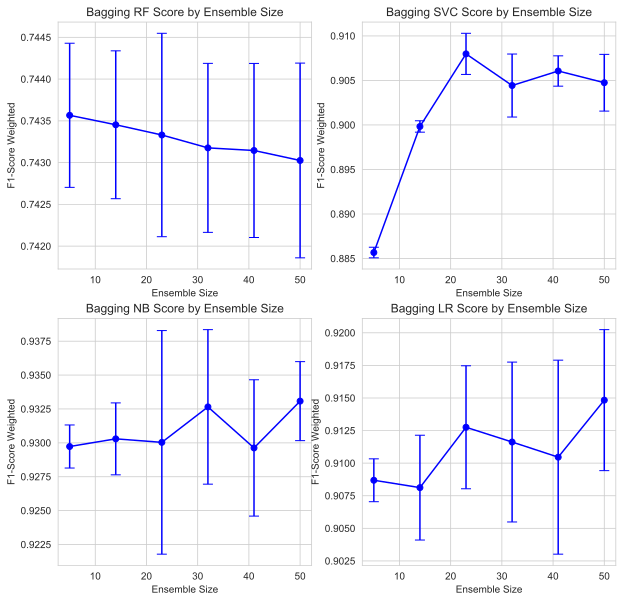

In [53]:
clf_list = [clf1, clf2, clf3, clf4]
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']

fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

scores_mean_dict = {}
scores_std_dict = {}
scores_dict = {}

for clf, label, grd in zip(clf_list, labels, grid):  
    num_est = map(int, np.linspace(5,50,6))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    row_results = [] 
    for n_est in num_est:    
        bg_clf = BaggingClassifier(base_estimator=clf, n_estimators=n_est, max_samples=0.8, max_features=0.8)
        scores = cross_val_score(bg_clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())
        row_results.append([label, scores.mean(), scores.std(), n_est])

    scores_mean_dict[label] = bg_clf_cv_mean
    scores_std_dict[label] = bg_clf_cv_std
    scores_dict[label] = row_results

    num_est = list(map(int, np.linspace(5,50,6)))
    ax = plt.subplot(gs[grd[0], grd[1]]) 

    (_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)
                                                                                         
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');
plt.show()

#### Get best Ensemble Size for each Model

In [54]:
best_no_of_est_dict = {}
labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']
for label in labels:
    scores_df = pd.DataFrame(scores_dict[label], columns=["name", "f1_mean", "f1-std", "num_est"])
    Opt_no_of_est = int(scores_df.sort_values(by='f1_mean', ascending=False).iloc[0]['num_est'])
    best_no_of_est_dict[label] = Opt_no_of_est
best_no_of_est_dict

{'Bagging RF': 5, 'Bagging SVC': 23, 'Bagging NB': 50, 'Bagging LR': 50}

In [55]:
bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=best_no_of_est_dict['Bagging RF'], max_samples=0.9)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=best_no_of_est_dict['Bagging SVC'], max_samples=0.8)
bagging3 = BaggingClassifier(base_estimator=clf3, n_estimators=best_no_of_est_dict['Bagging NB'], max_samples=0.8)
bagging4 = BaggingClassifier(base_estimator=clf4, n_estimators=best_no_of_est_dict['Bagging LR'], max_samples=0.8)

In [56]:
from mlxtend.plotting import plot_decision_regions
import itertools
import matplotlib.gridspec as gridspec

labels = ['Bagging RF', 'Bagging SVC', 'Bagging NB','Bagging LR']
clf_list = [bagging1, bagging2, bagging3, bagging4]

for clf, label, model_id in zip(clf_list, labels, model_ids):          
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    results = Result_Update_Or_Append(model_id, label, 'optimized', 'tuned', '', scores.mean(), False)
    print("F1-Score Weighted: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

cv_df = pd.DataFrame(results, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])

F1-Score Weighted: 0.74 (+/- 0.00) [Bagging RF]
F1-Score Weighted: 0.91 (+/- 0.00) [Bagging SVC]
F1-Score Weighted: 0.93 (+/- 0.00) [Bagging NB]
F1-Score Weighted: 0.91 (+/- 0.00) [Bagging LR]


In [57]:
cv_df

,Model_Id,Model,Features,Hyper_Param,Best_Params,F1_Score
0,RF,RandomForestClassifier,baseline,default,,0.8553093
1,SVC,LinearSVC,baseline,default,,0.9093070
2,NB,MultinomialNB,baseline,default,,0.8601395
3,LR,LogisticRegression,baseline,default,,0.9179669
4,RF,RandomForestClassifier,optimized,default,,0.8818303
5,SVC,LinearSVC,optimized,default,,0.8946894
6,NB,MultinomialNB,optimized,default,,0.9263994
7,LR,LogisticRegression,optimized,default,,0.9176636
8,RF,RandomForestClassifier,optimized,tuned,"{'max_depth': 6, 'n_estimators': 110, 'random_state': 0}",0.7435265
9,SVC,LinearSVC,optimized,tuned,"{'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1100, 'penalty': 'l1'}",0.8929360


The Bagging ensemble did not provide any improvements on the baseline and optimized modeling.

## Boosting

In [58]:
from sklearn.ensemble import AdaBoostClassifier

boosting1 = AdaBoostClassifier(base_estimator=clf1)
boosting2 = AdaBoostClassifier(base_estimator=clf2, algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3)
boosting4 = AdaBoostClassifier(base_estimator=clf4)

## Boosting Scores Varied by Ensemble Size

In [59]:
from sklearn.ensemble import AdaBoostClassifier

bst_list = [boosting1, boosting2, boosting3, boosting4]
labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

scores_mean_dict = {}
scores_std_dict = {}
scores_dict = {}

num_est = map(int, np.linspace(5,30,6))

for boosting, label in zip(bst_list, labels):  
    num_est = map(int, np.linspace(1,30,5))
    bg_clf_cv_mean = []
    bg_clf_cv_std = []
    row_results = [] 
    for n_est in num_est:
        boosting.set_params(n_estimators=n_est)
        scores = cross_val_score(boosting, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
        bg_clf_cv_mean.append(scores.mean())
        bg_clf_cv_std.append(scores.std())
        row_results.append([label, scores.mean(), scores.std(), n_est])
        print("F1-Score Weighted: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label + ', n_estimators: ' + str(n_est)))
    scores_mean_dict[label] = bg_clf_cv_mean
    scores_std_dict[label] = bg_clf_cv_std
    scores_dict[label] = row_results

F1-Score Weighted: 0.74 (+/- 0.00) [AdaBoost RF, n_estimators: 1]
F1-Score Weighted: 0.85 (+/- 0.02) [AdaBoost RF, n_estimators: 8]
F1-Score Weighted: 0.86 (+/- 0.01) [AdaBoost RF, n_estimators: 15]
F1-Score Weighted: 0.87 (+/- 0.01) [AdaBoost RF, n_estimators: 22]
F1-Score Weighted: 0.87 (+/- 0.01) [AdaBoost RF, n_estimators: 30]
F1-Score Weighted: 0.90 (+/- 0.01) [AdaBoost SVC, n_estimators: 1]
F1-Score Weighted: 0.90 (+/- 0.01) [AdaBoost SVC, n_estimators: 8]
F1-Score Weighted: 0.91 (+/- 0.01) [AdaBoost SVC, n_estimators: 15]
F1-Score Weighted: 0.90 (+/- 0.01) [AdaBoost SVC, n_estimators: 22]
F1-Score Weighted: 0.90 (+/- 0.01) [AdaBoost SVC, n_estimators: 30]
F1-Score Weighted: 0.73 (+/- 0.00) [AdaBoost NB, n_estimators: 1]
F1-Score Weighted: 0.52 (+/- 0.04) [AdaBoost NB, n_estimators: 8]
F1-Score Weighted: 0.74 (+/- 0.03) [AdaBoost NB, n_estimators: 15]
F1-Score Weighted: 0.78 (+/- 0.02) [AdaBoost NB, n_estimators: 22]
F1-Score Weighted: 0.79 (+/- 0.02) [AdaBoost NB, n_estimators: 

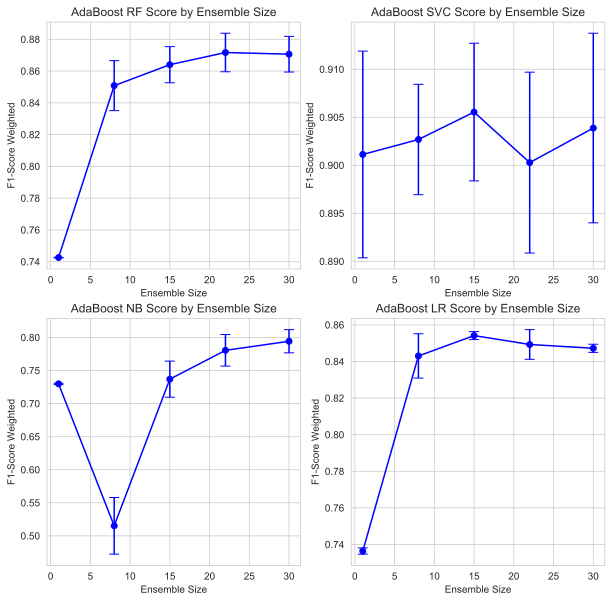

In [60]:
fig2 = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for label, grd in zip(labels, grid): 
    ax = plt.subplot(gs[grd[0], grd[1]]) 
    num_est = list(map(int, np.linspace(1,30,5)))
    (_, caps, _) = plt.errorbar(num_est, scores_mean_dict[label], yerr=scores_std_dict[label], c='blue', fmt='-o', capsize=5)
    for cap in caps:
        cap.set_markeredgewidth(1)                                                                                                                                
    fig2 = plt.ylabel('F1-Score Weighted'); plt.xlabel('Ensemble Size'); plt.title(label + ' Score by Ensemble Size');
plt.show()

## Learning Curves for Boosted Models

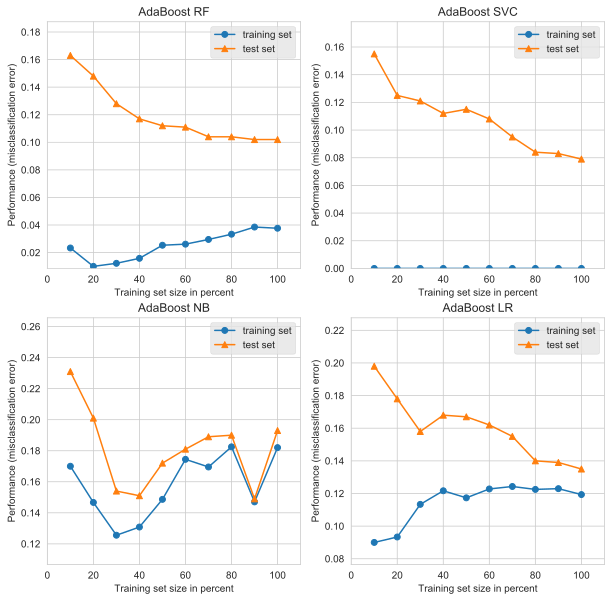

In [61]:
#plot Boosting learning curve
fig_bst = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for boosting, label, grd in zip(bst_list, labels, grid):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig_bst = plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, boosting, print_model=False, style='ggplot')
    plt.title(label)
plt.show()

#### Get best Ensemble Size for each Model 

In [62]:
best_no_of_est_dict = {}
for label in labels:
    scores_df = pd.DataFrame(scores_dict[label], columns=["name", "f1_mean", "f1-std", "num_est"])
    Opt_no_of_est = int(scores_df.sort_values(by='f1_mean', ascending=False).iloc[0]['num_est'])
    best_no_of_est_dict[label] = Opt_no_of_est
best_no_of_est_dict

{'AdaBoost RF': 22, 'AdaBoost SVC': 15, 'AdaBoost NB': 30, 'AdaBoost LR': 15}

In [63]:
boosting1 = AdaBoostClassifier(base_estimator=clf1, n_estimators=best_no_of_est_dict['AdaBoost RF'])
boosting2 = AdaBoostClassifier(base_estimator=clf2, n_estimators=best_no_of_est_dict['AdaBoost SVC'], algorithm='SAMME')
boosting3 = AdaBoostClassifier(base_estimator=clf3, n_estimators=best_no_of_est_dict['AdaBoost NB'])
boosting4 = AdaBoostClassifier(base_estimator=clf4, n_estimators=best_no_of_est_dict['AdaBoost LR'])
boost_list = [boosting1, boosting2, boosting3, boosting4]
labels_bst = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']

In [64]:
from sklearn.ensemble import AdaBoostClassifier

labels = ['AdaBoost RF', 'AdaBoost SVC', 'AdaBoost NB','AdaBoost LR']
bst_list = [boosting1, boosting2, boosting3, boosting4]

for boosting, label, model_id in zip(bst_list, labels, model_ids):
    
    scores = cross_val_score(boosting, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    results = Result_Update_Or_Append(model_id, label, 'optimized', 'tuned', '', scores.mean(), False)
    print("F1-Score Weighted: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))

cv_df = pd.DataFrame(results, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])

F1-Score Weighted: 0.87 (+/- 0.02) [AdaBoost RF]
F1-Score Weighted: 0.90 (+/- 0.01) [AdaBoost SVC]
F1-Score Weighted: 0.79 (+/- 0.02) [AdaBoost NB]
F1-Score Weighted: 0.85 (+/- 0.00) [AdaBoost LR]


In [65]:
cv_df

,Model_Id,Model,Features,Hyper_Param,Best_Params,F1_Score
0,RF,RandomForestClassifier,baseline,default,,0.8553093
1,SVC,LinearSVC,baseline,default,,0.9093070
2,NB,MultinomialNB,baseline,default,,0.8601395
3,LR,LogisticRegression,baseline,default,,0.9179669
4,RF,RandomForestClassifier,optimized,default,,0.8818303
5,SVC,LinearSVC,optimized,default,,0.8946894
6,NB,MultinomialNB,optimized,default,,0.9263994
7,LR,LogisticRegression,optimized,default,,0.9176636
8,RF,RandomForestClassifier,optimized,tuned,"{'max_depth': 6, 'n_estimators': 110, 'random_state': 0}",0.7435265
9,SVC,LinearSVC,optimized,tuned,"{'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1100, 'penalty': 'l1'}",0.8929360


The Boosting ensemble did not provide any improvements on the baseline and optimized modeling.

## Stacking

In [66]:
from mlxtend.classifier import StackingClassifier

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=clf4)

labels = ['Random Forest', 'LinearSVC', 'MultinomialNB', 'Stacking LR']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, labels, grid):
        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking LR'):
        results = Result_Update_Or_Append('Stack', label, 'optimized', 'tuned', '', scores.mean(), False)
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

Accuracy: 0.74 (+/- 0.00) [Random Forest]
Accuracy: 0.89 (+/- 0.01) [LinearSVC]
Accuracy: 0.94 (+/- 0.01) [MultinomialNB]
Accuracy: 0.88 (+/- 0.00) [Stacking LR]


<Figure size 1000x800 with 0 Axes>

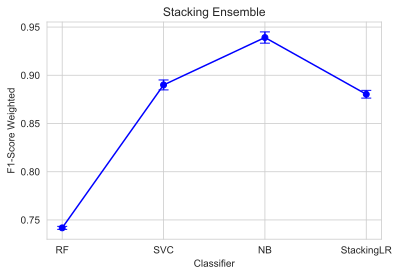

In [67]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['RF', 'SVC', 'NB', 'StackingLR'])        
plt.ylabel('F1-Score Weighted'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

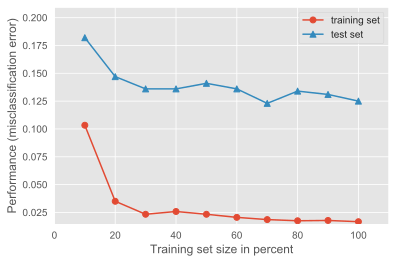

In [68]:
#plot Stacking learning curve
plt.figure()
plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, sclf, print_model=False, style='ggplot')
plt.show()

In [69]:
from mlxtend.classifier import StackingClassifier

sclf_bst = StackingClassifier(classifiers=[boosting1, boosting2, boosting3], meta_classifier=clf4)

labels = ['Boosted RF', 'Boosted SVC', 'Boosted NB', 'Stacking Boosted LR']
bst_list = [boosting1, boosting2, boosting3, sclf_bst]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(bst_list, labels, grid):
        
    scores = cross_val_score(clf, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    print("F1-Score Weighted: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    if (label == 'Stacking Boosted LR'):
        results = Result_Update_Or_Append('Stack', label, 'optimized', 'tuned', '', scores.mean(), False)
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())

F1-Score Weighted: 0.87 (+/- 0.02) [Boosted RF]
F1-Score Weighted: 0.90 (+/- 0.01) [Boosted SVC]
F1-Score Weighted: 0.79 (+/- 0.02) [Boosted NB]
F1-Score Weighted: 0.86 (+/- 0.00) [Stacking Boosted LR]


<Figure size 1000x800 with 0 Axes>

The Stacking performed poorly on our modeling.

## Voting

In [70]:
from sklearn.ensemble import VotingClassifier

clf2 = svm.SVC(kernel='linear', probability=True)

labels = ['hard', 'soft']

for label in labels:
    eclf1 = VotingClassifier(estimators=[('Random Forest', clf1), ('LinearSVC', clf2), ('MultinomialNB', clf3), ('Logistic Regression', clf4)], voting=label)
    scores = cross_val_score(eclf1, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
    print("F1-Score Weighted: %.7f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), "Voting: " + label))
    results = Result_Update_Or_Append('Voting', 'Voting ' + label, 'optimized', 'tuned', '', scores.mean(), False)

eclf2 = VotingClassifier(estimators=[('Random Forest', clf1), ('LinearSVC', clf2), ('MultinomialNB', clf3), ('Logistic Regression', clf4)], voting='soft', weights=[1.5, 0.7,1.5,0.9], flatten_transform=True)
scores = cross_val_score(eclf2, rm_chi_opt_bow.x_train_sel, y_train, cv=3, scoring='f1_weighted')
print("F1-Score Weighted: %.7f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), "Weighted Voting: " + label))
results = Result_Update_Or_Append('Voting', 'Weighted Voting soft', 'optimized', 'tuned', '', scores.mean(), False)

cv_df = pd.DataFrame(results, columns=['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score'])

F1-Score Weighted: 0.9119397 (+/- 0.01) [Voting: hard]
F1-Score Weighted: 0.9275496 (+/- 0.01) [Voting: soft]
F1-Score Weighted: 0.9336976 (+/- 0.00) [Weighted Voting: soft]


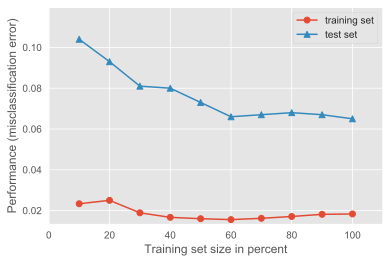

In [71]:
#plot Voting learning curve
plt.figure()
plot_learning_curves(rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test, eclf2, print_model=False, style='ggplot')
plt.show()

## New Method: - A Keras Based LSTM RNN Classifier on a Word2Vec Feature matrix

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [108]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

class KerasTextClassifier:
    __author__ = "Edward Ma"
    __copyright__ = "Copyright 2018, Edward Ma"
    __credits__ = ["Edward Ma"]
    __license__ = "Apache"
    __version__ = "2.0"
    __maintainer__ = "Edward Ma"
    __email__ = "makcedward@gmail.com"
    
    OOV_TOKEN = "UnknownUnknown"
    
    def __init__(self, 
                 max_word_input, word_cnt, word_embedding_dimension, labels, 
                 batch_size, epoch, validation_split,
                 verbose=0):
        self.verbose = verbose
        self.max_word_input = max_word_input
        self.word_cnt = word_cnt
        self.word_embedding_dimension = word_embedding_dimension
        self.labels = labels
        self.batch_size = batch_size
        self.epoch = epoch
        self.validation_split = validation_split
        
        self.label_encoder = None
        self.classes_ = None
        self.tokenizer = None
        
        self.model = self._init_model()
        self._init_label_encoder(y=labels)
        self._init_tokenizer()
        
    def _init_model(self):
        input_layer = Input((self.max_word_input,))
        text_embedding = Embedding(
            input_dim=self.word_cnt+2, output_dim=self.word_embedding_dimension,
            input_length=self.max_word_input, mask_zero=False)(input_layer)
        
        text_embedding = SpatialDropout1D(0.5)(text_embedding)
        
        bilstm = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.5))(text_embedding)
        x = concatenate([GlobalAveragePooling1D()(bilstm), GlobalMaxPooling1D()(bilstm)])
        x = Dropout(0.5)(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.5)(x)
        
        output_layer = Dense(units=len(self.labels), activation="softmax")(x)
        model = Model(input_layer, output_layer)
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
        return model
    
    def _init_tokenizer(self):
        self.tokenizer = Tokenizer(
            num_words=self.word_cnt+1, split=' ', oov_token=self.OOV_TOKEN)
    
    def _init_label_encoder(self, y):
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(y)
        self.classes_ = self.label_encoder.classes_
        
    def _encode_label(self, y):
        return self.label_encoder.transform(y)
        
    def _decode_label(self, y):
        return self.label_encoder.inverse_transform(y)
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.max_word_input, value=0)
    
    def _preprocess(self, texts):
        # Placeholder only.
        return [text for text in texts]
        
    def _encode_feature(self, x):
        #self.tokenizer.fit_on_texts(self._preprocess(x))
        self.tokenizer.fit_on_texts(x)
        self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.word_cnt}
        self.tokenizer.word_index[self.tokenizer.oov_token] = self.word_cnt + 1
        return self._get_sequences(self._preprocess(x))
        
    def fit(self, X, y):
        """
            Train the model by providing x as feature, y as label
        
            :params x: List of sentence
            :params y: List of label
        """
        
        encoded_x = X #self._encode_feature(X)
        encoded_y = self._encode_label(y)
        
        self.model.fit(encoded_x, encoded_y, 
                       batch_size=self.batch_size, epochs=self.epoch, 
                       validation_split=self.validation_split)
        
    def predict_proba(self, X, y=None):
        encoded_x = self._get_sequences(self._preprocess(X))
        return self.model.predict(encoded_x)
    
    def predict(self, X, y=None):
        y_pred = np.argmax(self.predict_proba(X), axis=1)
        return self._decode_label(y_pred)

In [109]:
names = ['Keras']
def build_model(names, x, y):
    pipelines = []

    for name in names:
        print('train %s' % name)

        pipeline = KerasTextClassifier(
            max_word_input=100, word_cnt=30000, word_embedding_dimension=100, 
            labels=list(set(y_train.tolist())), batch_size=128, epoch=500, validation_split=0.1)
        
        pipeline.fit(x, y)
        pipelines.append({'name': name, 'pipeline': pipeline})
        
    return pipelines

In [110]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

In [111]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [112]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.2864973,-0.9360336,-0.3424933,-0.1043627,0.1636438,-0.1199319,0.6321937,-2.3666761,-1.1843536,0.2726124,-0.4062230,-1.1585712,0.5085739,-1.2552611,0.4556002,...,-1.6043167,0.3590649,-0.0097224,0.1684880,0.2652265,-0.1941313,-0.5540912,-0.4567908,0.3291540,-0.0722905,-1.5320011,-1.3286988,2.5332706,-0.6861136,0.0604952
1,0.2669697,0.4083282,0.2413012,-0.0884836,0.2531653,-0.1035379,-0.5464737,-0.8313206,1.3046507,0.6741079,1.3090084,-2.0259537,0.1189846,-0.4425436,0.7897381,...,-1.7156734,1.2103394,-1.6276573,0.7343868,0.6460972,-0.6956273,0.6380528,-0.1322014,0.7845514,0.7640527,-1.7021188,0.6094897,0.5151652,-2.1282070,-0.3680622
2,0.6335197,-0.1606647,-0.5390858,-0.0496869,2.4321472,1.3920591,1.6782363,-0.6457997,-0.4264472,-1.0974309,0.9374455,-0.0358930,0.8184907,-0.6758988,-0.1849452,...,-1.2549543,0.4038325,-0.4232941,0.0553260,0.6925271,0.1051946,0.5582198,-1.3120891,0.6533034,0.6303997,-0.0946720,0.8326556,0.0561295,-1.2746182,0.3470083
3,0.2925620,-0.3179363,0.3965149,-0.9627657,-0.0418020,0.8882207,1.0591844,0.6959534,0.5960724,-0.0994822,-0.4363986,0.5482139,0.5049247,1.2677926,-1.3751351,...,0.0887679,-0.1791959,0.5667542,-0.6659912,0.8515783,0.3941339,1.1314251,-1.2292578,0.9898489,-0.4036834,0.6140916,0.3190180,0.2981810,1.0142114,0.4815035
4,0.0776665,0.1289886,-0.6674887,-0.5090024,-0.8971190,0.0377819,0.5923211,0.3311333,0.2732079,0.5399779,0.0194375,-0.6826337,1.1891023,1.0049514,-0.0498787,...,0.0487189,0.2511822,0.2579714,-0.8656218,0.7727166,-0.3136637,-0.7918115,-0.8475632,-0.2054645,1.4172354,0.2918180,-0.5548129,-0.8230939,-0.5177092,0.6432322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.9518359,-2.0421330,0.8395867,-0.8956777,0.6222661,0.1441335,0.0122127,-2.1477283,0.2371541,0.8851617,0.2077909,-1.3263335,0.2944896,-1.4985894,0.7240628,...,-1.2881250,0.4512795,-0.2115280,1.1324586,0.3531665,-0.4586064,0.1692226,-0.3312383,0.1333790,-0.5808259,-0.3412882,-1.0188943,2.0796416,-0.6730606,-0.2903278
2996,0.0650563,-1.3382927,-0.8535196,-1.1927645,0.3880179,0.5467004,-0.0873889,0.2323860,1.0952737,0.6389262,0.5466221,-2.1895121,0.9274266,0.1920254,-0.1538035,...,-0.4657554,0.5102293,0.2572024,0.0242290,0.1973823,0.3157123,-0.0617847,-0.4594944,-0.1188043,-0.1412855,0.5998505,-0.7118315,-1.3639284,-0.9297303,0.3354228
2997,-0.5393598,-1.1346181,0.9904135,-1.2817711,0.9009732,1.5303619,0.7365982,0.1770549,0.0518085,0.0676978,-0.3696724,-0.2574998,0.3095073,1.2686068,-1.1907887,...,-0.0936955,-0.1518658,0.3534285,-1.4777209,2.0040622,-0.0638985,0.5618919,-0.5680153,1.3009153,-0.9780312,0.3782058,0.5655475,-0.2141872,0.4407155,-0.2334329
2998,-0.2724698,-1.2151894,0.7283704,-1.3387874,-0.5114372,-0.7361417,-1.4685744,-0.8852763,-0.1464072,1.3552484,1.0149104,-1.2191165,-0.1860286,0.0636748,0.6571467,...,-1.5355122,0.8077289,-1.3562456,1.2363474,-0.2908315,-0.5333284,-0.1468762,-0.1085651,0.6696927,0.0069380,-0.4889132,-0.8007223,0.4144088,-0.4067344,-0.5684019


In [113]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(1000, 100)


In [114]:
lstm_model = KerasTextClassifier(
                max_word_input=100, word_cnt=30000, word_embedding_dimension=100, 
                labels=list(set(y_train.tolist())), batch_size=128, epoch=150, validation_split=0.2)
#pipelines = build_model(names, w2v_feature_array, y_train)
lstm_model.fit(w2v_feature_array, y_train)

uracy: 0.3619 - val_loss: 1.5328 - val_accuracy: 0.4500
Epoch 15/150
2700/2700 [==============================] - 3s 1ms/step - loss: 1.6559 - accuracy: 0.3889 - val_loss: 1.4788 - val_accuracy: 0.4267
Epoch 16/150
2700/2700 [==============================] - 3s 1ms/step - loss: 1.6094 - accuracy: 0.4030 - val_loss: 1.4365 - val_accuracy: 0.4567
Epoch 17/150
2700/2700 [==============================] - 3s 1ms/step - loss: 1.5808 - accuracy: 0.4274 - val_loss: 1.4019 - val_accuracy: 0.5000
Epoch 18/150
2700/2700 [==============================] - 3s 1ms/step - loss: 1.5374 - accuracy: 0.4396 - val_loss: 1.3525 - val_accuracy: 0.4867
Epoch 19/150
2700/2700 [==============================] - 4s 1ms/step - loss: 1.5067 - accuracy: 0.4481 - val_loss: 1.3311 - val_accuracy: 0.4633
Epoch 20/150
2700/2700 [==============================] - 3s 1ms/step - loss: 1.4902 - accuracy: 0.4585 - val_loss: 1.3137 - val_accuracy: 0.4833
Epoch 21/150
2700/2700 [==============================] - 3s 1ms/ste

## Summary of Findings

#### Benchmarking of F1 Scores for Baseline Models and Bagging, Boosting, Stacking, and Voting Ensembles

In [72]:
result_df = cv_df
result_df[['Model_Id','Model', 'Features', 'Hyper_Param', 'Best_Params', 'F1_Score']]

,Model_Id,Model,Features,Hyper_Param,Best_Params,F1_Score
0,RF,RandomForestClassifier,baseline,default,,0.8553093
1,SVC,LinearSVC,baseline,default,,0.9093070
2,NB,MultinomialNB,baseline,default,,0.8601395
3,LR,LogisticRegression,baseline,default,,0.9179669
4,RF,RandomForestClassifier,optimized,default,,0.8818303
5,SVC,LinearSVC,optimized,default,,0.8946894
6,NB,MultinomialNB,optimized,default,,0.9263994
7,LR,LogisticRegression,optimized,default,,0.9176636
8,RF,RandomForestClassifier,optimized,tuned,"{'max_depth': 6, 'n_estimators': 110, 'random_state': 0}",0.7435265
9,SVC,LinearSVC,optimized,tuned,"{'C': 1200, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1100, 'penalty': 'l1'}",0.8929360


---

#### Model Evaluation Results with F1 Score

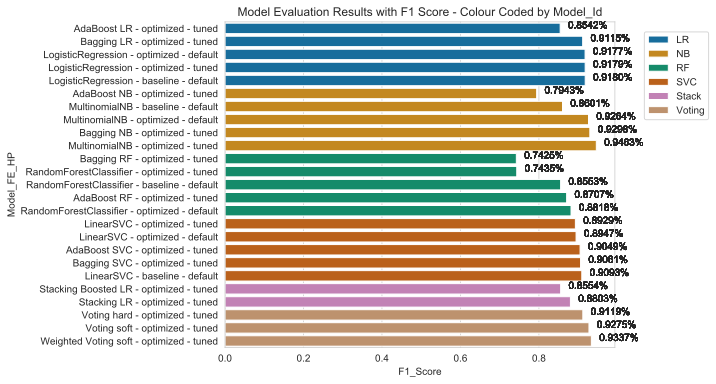

In [73]:
result_df['Model_FE_HP'] = result_df['Model'] + ' - ' + result_df['Features'] + ' - ' + result_df['Hyper_Param']
#fig = plt.subplots(figsize=(6, 6))
fig, (ax1) = plt.subplots(figsize=(7, 6), ncols=1)
g = sns.barplot(x='F1_Score', y='Model_FE_HP', data=result_df.sort_values(by=['Model_Id','F1_Score']), palette="colorblind", hue='Model_Id', dodge=False, ci=None, ax=ax1)
plt.title("Model Evaluation Results with F1 Score - Colour Coded by Model_Id")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.)

total = len(result_df['Model_FE_HP'])
def annotateBars(row, ax=ax): 
    for p in ax.patches:
        val = '{:.4f}%'.format(p.get_width())
        #percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(val, (x, y))

plot = result_df.apply(annotateBars, ax=ax1, axis=1)
plt.show()


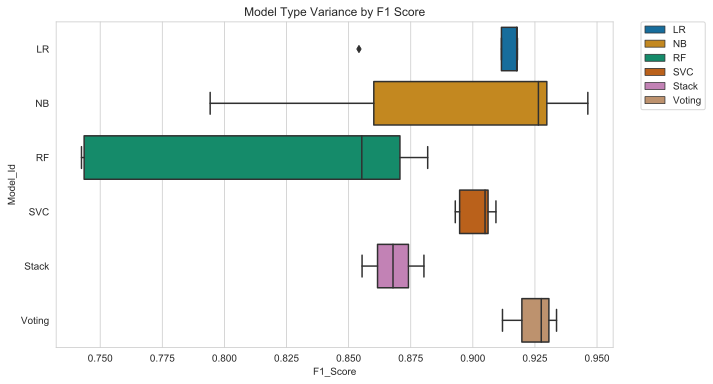

In [74]:
fig = plt.subplots(figsize=(10, 6))
sns.boxplot(x='F1_Score', y='Model_Id', data=result_df.sort_values(by='Model_Id'), palette="colorblind", hue='Model_Id', dodge=False)
plt.title("Model Type Variance by F1 Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

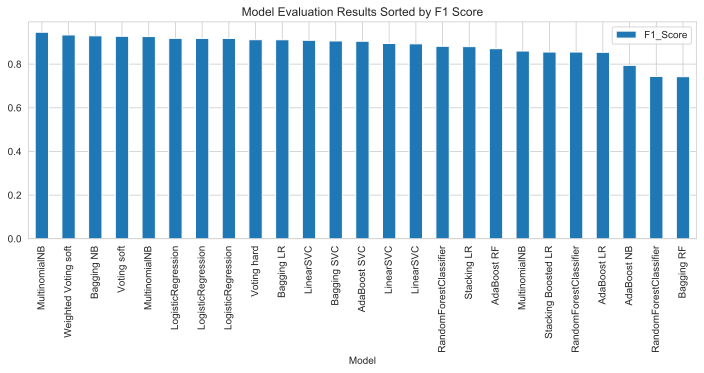

In [75]:
result_df.sort_values(by='F1_Score', ascending=False).\
plot(y="F1_Score", x="Model", kind='bar', title="Model Evaluation Results Sorted by F1 Score", figsize=(12, 4));

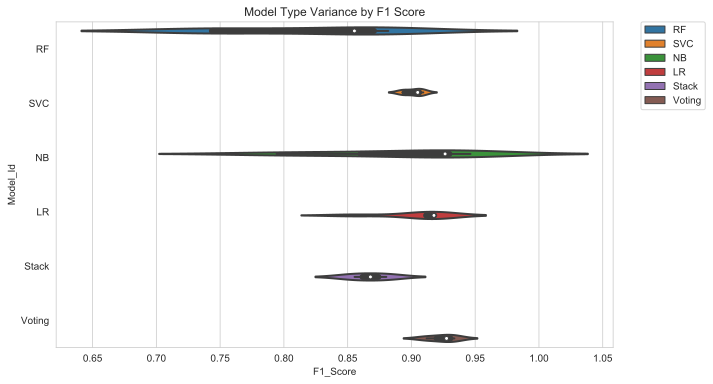

In [76]:
fig = plt.subplots(figsize=(10, 6))
#sns.boxplot(x='F1_Score', y='Model_Id', data=result_df.sort_values(by='Model_Id'), palette="colorblind", hue='Model_Id', dodge=False)
plt.title("Model Type Variance by F1 Score")
sns.violinplot(x='F1_Score', y='Model_Id', data=result_df, hue='Model_Id', size=6, jitter=True, edgecolor="gray", linewidth=2);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [77]:
clf_final_results = Build_Model(eclf2, rm_chi_opt_bow.x_train_sel, y_train, rm_chi_opt_bow.x_test_sel, y_test)

In [78]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

In [79]:
print("Label" + clf_final_results.report)

Label              precision    recall  f1-score   support

           0       0.92      0.96      0.94       143
           1       0.85      0.92      0.88       153
           2       0.92      0.77      0.84        44
           3       0.99      1.00      1.00       124
           4       1.00      0.99      0.99       158
           5       0.98      1.00      0.99       108
           6       0.99      0.99      0.99       144
           7       0.83      0.78      0.80        97
           8       0.92      0.92      0.92        12
           9       0.56      0.29      0.38        17

    accuracy                           0.93      1000
   macro avg       0.89      0.86      0.87      1000
weighted avg       0.93      0.93      0.93      1000



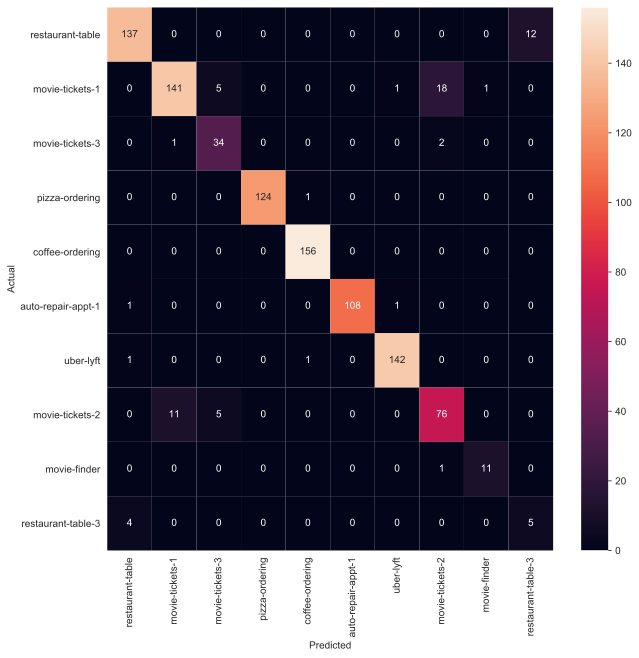

In [80]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(clf_final_results.cm, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()